## Лабораторная работа 4.4.3

In [2907]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import tikzplotlib as tikz
import regex as rg

In [2908]:
def csvtotex(input, output, columns=None, rows=[-1], type=None, transp=False):
    df = pd.read_csv(input, sep=",", usecols=columns, quotechar='"', dtype=type)
    df = df[df.index.isin(rows)]
    if transp:
        df = df.transpose()
        pd.DataFrame.to_csv(df, output, sep="&", index=True)
        with open(output, "r") as data:
            content = data.readlines()
        with open(output, "w") as data:
            data.write("\\begin{tabular}{")
            for c in rows: data.write("|l")
            data.write("|l|}")
            data.write("\hline")
            content.pop(0)
            for str in content:
                data.write(str)
                data.write("\\\\")
                data.write("\hline")
            data.write("\end{tabular}")
    else:
        pd.DataFrame.to_csv(df, output, sep="&", index=False)
        with open(output, "r") as data:
            content = data.readlines()
        with open(output, "w") as data:
            data.write("\\begin{tabular}{")
            for c in columns: data.write("|l")
            data.write("|}")
            data.write("\hline")
            for str in content:
                data.write(str)
                data.write("\\\\")
                data.write("\hline")
            data.write("\end{tabular}")
    return df

In [2909]:
def print_err(a, a_err, vis=True):
    a = np.array([a]).flatten()
    a_err = np.array([a_err]).flatten()
    val = np.zeros_like(a)
    sig = np.zeros_like(a_err)
    for i in range(a.size):
        val[i] = np.round(a[i], decimals = round(1 * (np.trunc(np.log10(a_err[i]) < 0)) - np.trunc(np.log10(a_err[i]))))
        sig[i] = np.round(a_err[i], decimals = round(1 * (np.trunc(np.log10(a_err[i]) < 0)) - np.trunc(np.log10(a_err[i]))))
        if vis: print(val[i], '\pm', sig[i])
    return val, sig

In [2910]:
def T(n, x):
    return np.cos(n * np.arccos(x))

>### Измерение преломляющего угла

In [2930]:
df = pd.read_csv('../data/data.csv', usecols=range(3))
a1 = np.array([int(val) / 60 ** num for num, val in enumerate(rg.findall('(\d\d|\d)', str(df[df.columns[0]].values[0])))]).sum() / 180 * np.pi
a2 = np.array([int(val) / 60 ** num for num, val in enumerate(rg.findall('(\d\d|\d)', str(df[df.columns[1]].values[0])))]).sum() / 180 * np.pi
a2_err = np.array([int(val) / 60 ** num for num, val in enumerate(rg.findall('(\d\d|\d)', str(df[df.columns[2]].values[0])))]).sum() / 180 * np.pi
a = np.abs(a1 - a2)
a_err = a * (a2_err / a2)
print_err(a * 180 / np.pi, a_err * 180 / np.pi)
0.0003*3600
0.069*3600

60.0069 \pm 0.0003


248.40000000000003

>### Минимальный угол отклонения

In [2912]:
df = csvtotex('../data/data.csv', '../data/table1.tex', columns=range(8, 10), rows=range(8), transp=True)
display(df)

,0,1,2,3,4,5,6,7
"$\lambda$, нм",690.7,623.4,579.1,577.0,546.1,491.6,435.8,404.7
$\delta$,$51^{\circ}0'49''$,$51^{\circ}37'25''$,$52^{\circ}1'15''$,$52^{\circ}2'14''$,$52^{\circ}22'32''$,$53^{\circ}9'17''$,$54^{\circ}20'46''$,$55^{\circ}19'26''$


In [2913]:
df = df.transpose()

In [2914]:
delta = np.array([np.array([int(val) / 60 ** num for num, val in enumerate(i)]).sum() for i in np.array([rg.findall('(\d\d|\d)', str(i)) for i in df[df.columns[1]].values])]) / 180 * np.pi
delta_err = a2_err
lam = np.array(df[df.columns[0]].values, dtype=float)

In [2915]:
n = np.sin((a + delta) / 2) / np.sin(a / 2)
n_err = ((np.cos((a + delta) / 2) / (2 * np.sin(a / 2)) * delta_err) ** 2 +
        ((np.cos((a + delta) / 2) * np.sin(a / 2) - np.sin((a + delta) / 2) * np.cos(a / 2)) / (2 * np.sin(a / 2) ** 2) * a_err) ** 2) ** 0.5
lam_D = 589.3
lam_F = 486.1
lam_C = 656.3

In [2916]:
def fit(x, p0, p1, p2, p3):
    y = 0.5 * (x - (lam.max() + lam.min()) / 2) / (lam.max() - lam.min())
    return T(0, y) * p0 + T(1, y) * p1 + p2 * np.exp(-p3 * y)

In [2917]:
k, err = sp.curve_fit(fit, lam, n)

In [2918]:
n_D = fit(lam_D, k[0], k[1], k[2], k[3])
n_F = fit(lam_F, k[0], k[1], k[2], k[3])
n_C = fit(lam_C, k[0], k[1], k[2], k[3])

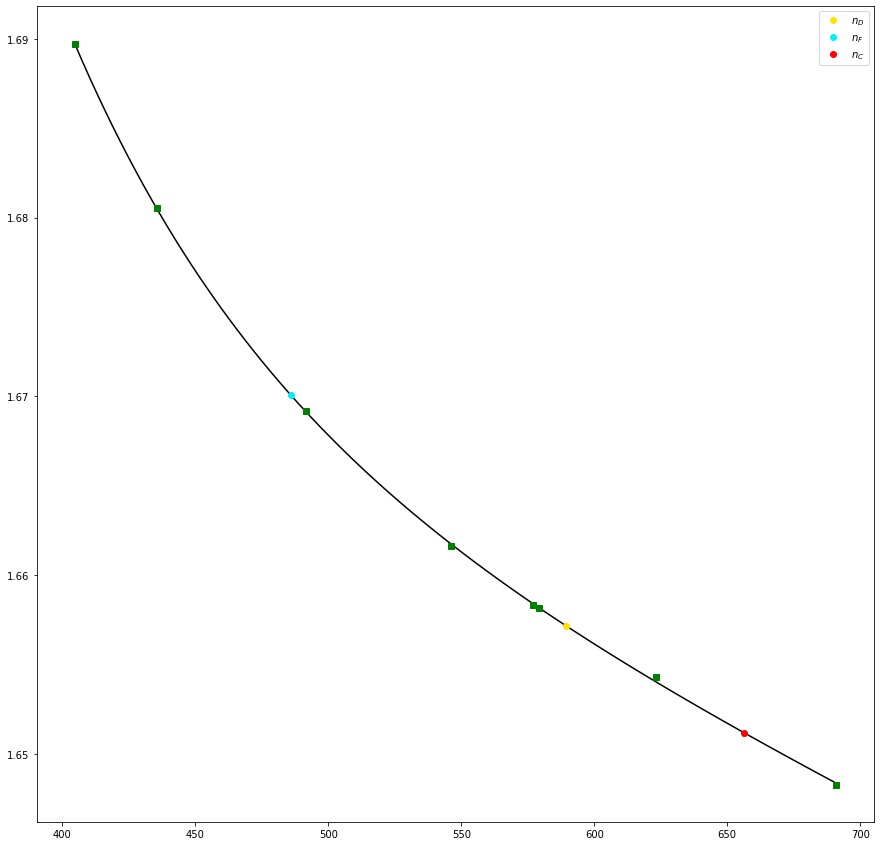

In [2919]:
plt.figure(figsize=(15, 15))

plt.errorbar(lam, n, yerr=n_err, fmt='s', color='green')
plt.plot(np.linspace(lam.min(), lam.max(), 100), fit(np.linspace(lam.min(), lam.max(), 100), k[0], k[1], k[2], k[3]), 'black')

plt.errorbar(lam_D, n_D, fmt='o', color='#ffe200', label='$n_D$')
plt.errorbar(lam_F, n_F, fmt='o', color='#00efff', label='$n_F$')
plt.errorbar(lam_C, n_C, fmt='o', color='#ff0000', label='$n_C$')

plt.legend()

plt.show()

#tikz.save('plot1.tex')

In [2920]:
df['$n$'], df['$\sigma_{n}$'] = print_err(n, n_err, vis=False)
pd.DataFrame.to_csv(df, '../data/calculated_n.csv', index=False)
csvtotex('../data/calculated_n.csv', '../data/table1.tex', columns=range(0, 4), rows=range(8), transp=True)

,0,1,2,3,4,5,6,7
"$\lambda$, нм",690.7,623.4,579.1,577.0,546.1,491.6,435.8,404.7
$\delta$,$51^{\circ}0'49''$,$51^{\circ}37'25''$,$52^{\circ}1'15''$,$52^{\circ}2'14''$,$52^{\circ}22'32''$,$53^{\circ}9'17''$,$54^{\circ}20'46''$,$55^{\circ}19'26''$
$n$,1.648283,1.654287,1.658172,1.658332,1.661625,1.669152,1.680513,1.689701
$\sigma_{n}$,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005


>### Число Аббе и средня дисперсия

In [2921]:
D = n_F - n_C
print(D)

0.01885938784083696


In [2922]:
nu = (n_D - 1) / (n_F - n_C)
print(np.round(nu, decimals=3))

34.846


In [2923]:
print(n_D, n_F, n_C)

1.657178506439584 1.6700468288511414 1.6511874410103045


>### Разрешающая способность

    По основанию

In [2924]:
eps = 0.000001
b = 7.3 * 10 ** (-2)
b_err = 0.1 * 10 ** (-2)
der = (fit(lam[2] + eps, k[0], k[1], k[2], k[3]) - fit(lam[2], k[0], k[1], k[2], k[3])) / (eps * 10 ** (-9))
R = b * der
R_err = abs(b_err / b * R)
R_err
print_err(R, R_err)

-7400.0 \pm 100.0


(array([-7400.]), array([100.]))

    По дуплету

In [2925]:
def fit1(x, p0, p1, p2, p3, h):
    y = 0.5 * (x - (lam.max() + lam.min()) / 2) / (lam.max() - lam.min())
    return T(0, y) * p0 + T(1, y) * p1 + p2 * np.exp(-p3 * y) - h

In [2931]:
delta_d = 5 / 3600
err_delta_d = 1 / 3600
delta_lam = sp.root(fit1, 570, args=(k[0], k[1], k[2], k[3], np.sin((a + delta[2] - delta_d / 2) / 2) / np.sin(a / 2)), ).x[0] - sp.root(fit1, 570, args=(k[0], k[1], k[2], k[3], np.sin((a + delta[2] + delta_d / 2) / 2) / np.sin(a / 2))).x[0]
R = lam[2] / (lam[2] - lam[3])
R_err = err_delta_d / delta_d * R
b = np.abs(R / der)
b_err = R_err / R * b
print_err(b * 100, b_err * 100)
(delta[2]-delta[3]) / (lam[2] - lam[3])

0.27 \pm 0.05


-0.00013620955802600841